In [ ]:
#Importing most necessary libraries here

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from efficientnet_pytorch import EfficientNet
from torchvision import transforms, datasets
from torch.utils.data import random_split
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import random

Defining Transforms

In [ ]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
!pip install torch torchvision timm
from timm import create_model

In [ ]:
cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
total_size = len(cifar_dataset)
pretrain_size = int(0.05 * total_size)
finetune_size = int(0.45 * total_size)
test_size = total_size - pretrain_size - finetune_size

# Split dataset into 5% for pre-training, 45% for fine-tuning, and 50% for testing, as specified in the task.
pretrain_dataset, remaining_dataset = random_split(cifar_dataset, [pretrain_size, total_size - pretrain_size])
finetune_dataset, test_dataset = random_split(remaining_dataset, [finetune_size, test_size])


Files already downloaded and verified


 To understand the effect  of supervised learning and pre-training, we need to compare the performance of the model at various stages.

 First of all, let us test the base capacity of our model. Let us see it's test accuracy without training it and see. This gives us an idea about the capability of the model in it's raw state and helps us compare with our results later. I have named this model "**model_empty**"

In [ ]:
model_empty = create_model('efficientnet_b6', pretrained=False)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
batch_size = 128
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_empty(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert the lists to NumPy arrays


In [ ]:
import numpy as np
predictions_np = np.array(predictions)
true_labels_np = np.array(true_labels)

# Calculate accuracy
accuracy_untrained = accuracy_score(true_labels_np, predictions_np)

In [ ]:

print(f'Test Accuracy for completely untrained model: {accuracy_untrained* 100:.5f}%')

Test Accuracy for completely untrained model: 0.02800%


On testing untrained model, we see an accuracy of 0.02%. This low accuracy is expected since the model hasn't been trained and has nt learned any weights. Moreover, since we have kept the pretrained parameter set to **False**, the model is initialised without any pre-trained weights.

In [ ]:
from PIL import Image

In [ ]:
!pip install efficientnet_pytorch

### Training and Testing, but no pre-training
Here, we will Train our model on the 45%-finetune dataset, and test it on the remaining 50%. However, no pretraining will be done.

EfficientNet model is being used.

In [ ]:

pretrain_loader = torch.utils.data.DataLoader(pretrain_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
finetune_loader = torch.utils.data.DataLoader(finetune_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
from tqdm import trange
from efficientnet_pytorch import EfficientNet

# Specify the EfficientNet model (e.g., EfficientNet-B0)
model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=10)  # 10 classes in CIFAR-10

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Loaded pretrained weights for efficientnet-b6


All experiments were initially carried out on my local PC using VSCode, however, were later shifted to Google Colab to gain GPU access.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:

num_epochs = 5
model = model.to(device)

# Training loop on the train dataset
for epoch in trange(num_epochs):
    for inputs, labels in finetune_loader:
        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Evaluation on the test dataset
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy}')



100%|██████████| 5/5 [03:42<00:00, 44.46s/it]


Test Accuracy: 0.80684


Here we see the accuracy of the model on being trained on the 45% finetune dataset, and tested on the 50% test dataset.

In [ ]:
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy}')


Test Accuracy: 0.80684


In [ ]:
accuracy_percentage_nopre = accuracy * 100
print(f'Test Accuracy: {accuracy_percentage_nopre:.2f}%')

Test Accuracy: 80.68%


The accuracy seen above is on training the model on 45% of the dataset and then testing on the remaining 50%. We can see the significant, and obvious, increase in accuracy, considering that the model has been trained on correct data.

### Self-supervised Learning task.

Below, we start the jigsaw puzzle transformation. In the reference provided by the sustainability lab, it was suggested to segment the image into 9 pieces, but I have gone with a 4-piece, i.e, a 2x2 grid, in the interest of time. In the first code block, we are simply dividing the image into 4 parts, and saving every permutation of the shuffled images, alongside their labels, which will help in performing the self-supervised task.

In [ ]:
import itertools
import numpy as np
from PIL import Image

bb = []
dd = []
label = [0,1,2,3]
label_permute = list(itertools.permutations(label))
h = 32
w = 32
for img, _ in pretrain_dataset:

        c, w, h = img.shape
        img_part = np.zeros((4, 3, h // 2, w // 2))
        img_part[0] = img[:, : h // 2, : w // 2]
        img_part[1] = img[:, h // 2 :, : w // 2]
        img_part[2] = img[:, : h // 2, w // 2 :]
        img_part[3] = img[:, h // 2 :, w // 2 :]

        for j,k in zip(label_permute, range(len(label_permute))):
            img_up = np.concatenate((img_part[j[0]], img_part[j[2]]), axis=2)
        # Combine the bottom-left and bottom-right parts
            img_down = np.concatenate((img_part[j[1]], img_part[j[3]]), axis=2)

        # Combine the top and bottom halves to create the final stitched image
            remade_image = np.concatenate((img_up, img_down), axis=1)
            pil_image = Image.fromarray((remade_image * 255).astype(np.uint8).transpose(1, 2, 0))

            bb.append(torch.tensor(remade_image, dtype=torch.float32))
            dd.append(torch.tensor(k))

In [ ]:
len(dd)
#should be 60000(2500x24)

60000

In [ ]:
from torch.utils.data import Dataset


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label

# Assuming you have lists 'image_list' and 'label_list'
# You can define a transform if needed (e.g., convert PIL image to tensor)
transform = transforms.Compose([transforms.ToTensor()])

# Create a CustomDataset
custom_dataset = CustomDataset(images=bb, labels=dd, transform=None)

# Create a DataLoader
batch_size = 128
ssl_data_loader = DataLoader(dataset=custom_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from tqdm import trange
import tqdm
from efficientnet_pytorch import EfficientNet

# Specify the EfficientNet model_ssl (e.g., EfficientNet-B0)
model_ssl = EfficientNet.from_pretrained('efficientnet-b6', num_classes=24)  # 10 classes in CIFAR-10

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ssl.parameters(), lr=0.001)

num_epochs = 10
model_ssl = model_ssl.to(device)


Loaded pretrained weights for efficientnet-b6


## Only SSL, No finetuning

In [ ]:
# Training loop on the train dataset
for epoch in trange(num_epochs):
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for inputs, labels in ssl_data_loader:

        optimizer.zero_grad()
        outputs = model_ssl(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels.to(device)).sum().item()
        total_samples += labels.size(0)

    # Calculate epoch-level metrics
    epoch_loss = total_loss / len(ssl_data_loader)
    epoch_accuracy = correct_predictions / total_samples

    # Display loss and accuracy after each epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")



 10%|█         | 1/10 [01:57<17:40, 117.86s/it]

Epoch 1/10, Loss: 1.3279, Accuracy: 0.5850


 20%|██        | 2/10 [03:54<15:39, 117.43s/it]

Epoch 2/10, Loss: 0.1462, Accuracy: 0.9564


 30%|███       | 3/10 [05:51<13:39, 117.00s/it]

Epoch 3/10, Loss: 0.0564, Accuracy: 0.9843


 40%|████      | 4/10 [07:48<11:42, 117.07s/it]

Epoch 4/10, Loss: 0.0421, Accuracy: 0.9889


 50%|█████     | 5/10 [09:46<09:46, 117.29s/it]

Epoch 5/10, Loss: 0.0331, Accuracy: 0.9913


 60%|██████    | 6/10 [11:43<07:49, 117.25s/it]

Epoch 6/10, Loss: 0.0294, Accuracy: 0.9922


 70%|███████   | 7/10 [13:39<05:50, 116.83s/it]

Epoch 7/10, Loss: 0.0284, Accuracy: 0.9930


 80%|████████  | 8/10 [15:36<03:53, 116.75s/it]

Epoch 8/10, Loss: 0.0284, Accuracy: 0.9932


 90%|█████████ | 9/10 [17:33<01:56, 116.81s/it]

Epoch 9/10, Loss: 0.0445, Accuracy: 0.9892


100%|██████████| 10/10 [19:29<00:00, 116.95s/it]

Epoch 10/10, Loss: 0.0294, Accuracy: 0.9931


In [ ]:


# Evaluation on the test dataset
model_ssl.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model_ssl(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = correct / total
accuracy_percentage = accuracy * 100
print(f'Test Accuracy: {accuracy_percentage:.5f}%')


Test Accuracy: 5.02400%



The accuracy obtained above (around 5%) is for when the SSL task is carried out followed by testing, nothing else. This low value is expected because we haven't trained it on a substantial amount of data. Moreover, we are training it on shuffled images to predict the permutation, and testing it by making it predict the correct class from the CIFAR-10 dataset.

However, we can see that this is a **significant increase from the 0.02% accuracy** we recorded on the completely untrained model, which shows that **valuable feature recognition and image patterns** are learnt during the SSL task, and are useful for the downstream classification task.

Now below, we will add a linear layer to make our model suitable for CIFAR-10 classification task.The model will carry forward the weights it has learned from the SSL task, and be further finetuned by training on the 45% finetune dataset.


In [ ]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

# Load pre-trained EfficientNet model
efficientnet_model = model_ssl
# Get the in_features of the last layer in the EfficientNet model
in_features = efficientnet_model._fc.in_features

Below we will define the architecture we want to replace the last layer of our EffNet architecture with.

In [ ]:
custom_model = nn.Sequential(
    nn.Linear(in_features=2304, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=10),  # Adjust out_features based on your requirement
    nn.Softmax(dim=1)  # Add softmax activation along dimension 1 (assuming a classification task)
)



In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model.to(device)
custom_model.to(device)

efficientnet_model._fc = nn.Linear(in_features=2304, out_features=10).to(device)




In [ ]:
from tqdm import trange
from efficientnet_pytorch import EfficientNet

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10


We use our modified model for the CIFAR-10 classification task below.

In [ ]:

num_epochs = 5
model = model.to(device)

# Training loop on the train dataset
for epoch in trange(num_epochs, desc='Epochs'):
    total_loss = 0.0
    total_samples = 0

    for inputs, labels in finetune_loader:
        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)

        outputs = efficientnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_samples += labels.size(0)

    average_loss = total_loss / total_samples

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}')


# Evaluation on the test dataset
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = efficientnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy}')



Epochs:  20%|██        | 1/5 [00:46<03:06, 46.62s/it]

Epoch 1/5, Loss: 0.0188


Epochs:  40%|████      | 2/5 [01:33<02:20, 46.79s/it]

Epoch 2/5, Loss: 0.0188


Epochs:  60%|██████    | 3/5 [02:20<01:33, 46.74s/it]

Epoch 3/5, Loss: 0.0188


Epochs:  80%|████████  | 4/5 [03:07<00:46, 46.82s/it]

Epoch 4/5, Loss: 0.0188


Epochs: 100%|██████████| 5/5 [03:53<00:00, 46.74s/it]

Epoch 5/5, Loss: 0.0188


Test Accuracy: 0.09708


In [ ]:


# Evaluation on the test dataset
efficientnet_model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = efficientnet_model(inputs.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy*100}')

Test Accuracy: 9.708


In [ ]:

print(f'Test Accuracy: {accuracy*100}')

Test Accuracy: 9.708


On finetuning the model on our finetune dataset, we can see that the accuracy has increased from 5% to 9.7%. This increase can be seen since the model has since been trained on the CIFAR-10 dataset to predict the correct class from the image.

However, I was expecting the model to outperform the experiment where training is done without the SSL pretraining, but unfortunately, I couldn't achieve those results. I tried various debugging statements, added print statements in various places, etc to debug the problem, but wasn't succesful. I even plotted some figures, including the confusion matrix, the Loss vs Epochs graph, etc, but couldn't reach the root of the problem.

I hope to learn in thourough depth once I join the team at the Sustainability lab :)


Confusion Matrix:
[[1 0 0 0 0 2 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0]
 [1 0 0 1 0 3 0 0 0 0]
 [4 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 1 0 0 0 0]
 [2 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 5 0 0 0 0]
 [3 0 0 0 1 2 0 0 0 0]
 [2 0 0 1 1 1 0 0 0 0]
 [2 0 0 0 0 1 0 0 0 0]]


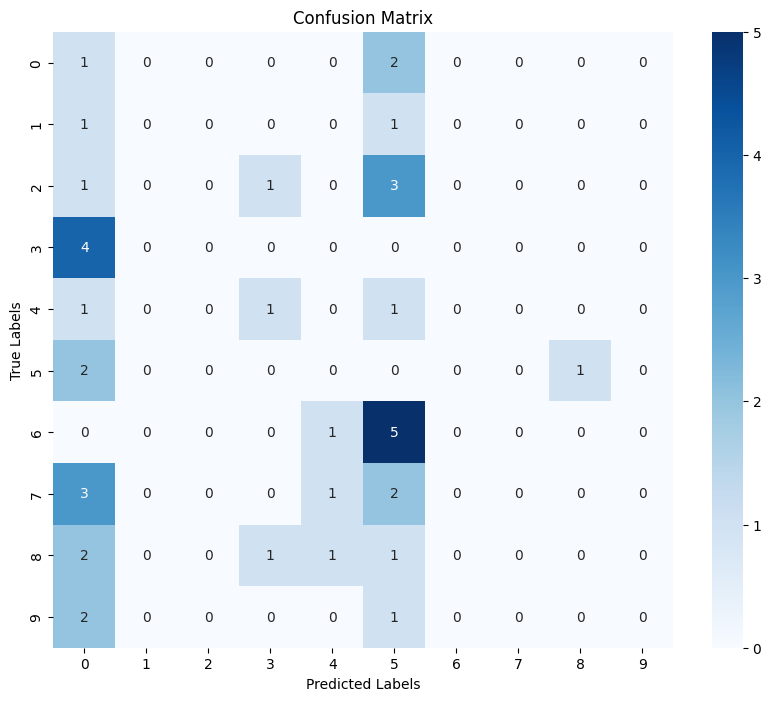

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(labels.cpu().numpy(), predicted.cpu().numpy())
print(f'\nConfusion Matrix:\n{conf_matrix}')

# Display the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Discarded Codes
Below are several app

In [ ]:
# # Training loop on the train dataset
# for epoch in trange(num_epochs):
#     for inputs, labels in finetune_loader:
#         print(inputs.shape)
#         print(labels.shape)
#         optimizer.zero_grad()

#         outputs = model(inputs.to(device))

#         # Add a singleton dimension to labels
#         labels = labels.unsqueeze(1)
#         labels = labels.unsqueeze(1)

#         loss = criterion(outputs, labels.to(device))
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()

#         # Calculate accuracy
#         _, predicted = torch.max(outputs, 1)
#         correct_predictions += (predicted == labels.to(device)).sum().item()
#         total_samples += labels.size(0)

#     # Calculate epoch-level metrics
#     epoch_loss = total_loss / len(finetune_loader)  # Fix the loader name
#     epoch_accuracy = correct_predictions / total_samples

#     # Display loss and accuracy after each epoch
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


In [ ]:
# from tqdm import trange

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(cfn_model.parameters(), lr=0.0001)
# # pretrain_loader = tqdm(pretrain_loader, total=len(pretrain_loader), desc="Pretraining")
# print(100)
# import matplotlib.pyplot as plt

# # Assuming cfn_model, criterion, optimizer, and data (bb, dd) are defined as before

# cfn_model.train()
# num_pretrain_epochs = 25
# losses = []  # To store losses for plotting

# for epoch in trange(num_pretrain_epochs):
#     epoch_losses = []
#     for inputs, label in zip(bb, dd):
#         optimizer.zero_grad()
#         inputs = inputs.unsqueeze(0)
#         # print(inputs.shape)
#         # print(label.shape)
#         # inputs = inputs.mean(dim=1, keepdim=True)
#         # inputs = inputs.repeat(1, 3, 1, 1)
#         outputs = cfn_model(inputs)
#         if not torch.is_tensor(label):
#             label = torch.tensor(label, dtype=torch.long)
#         label = label.reshape(1)
#         loss = criterion(outputs, label)
#         epoch_losses.append(loss.item())
#         loss.backward()
#         optimizer.step()

#     # Calculate average loss for the epoch
#     print(epoch_losses)
#     avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
#     losses.append(avg_epoch_loss)

#     print(f"Epoch: {epoch}, Avg Loss: {avg_epoch_loss}")

# # Plot loss vs epoch
# plt.plot(range(1, num_pretrain_epochs + 1), losses, marker='o')
# plt.title('Loss vs Epoch')
# plt.xlabel('Epoch')
# plt.ylabel('Average Loss')
# plt.show()


In [ ]:
# from tqdm import trange
# class JigsawPuzzleTransform:
#     def __init__(self, grid_size=1):
#         self.grid_size = grid_size

#     def __call__(self, img):
#         # Assuming img is a PIL Image
#         w, h = img.size
#         patch_size = w // self.grid_size

#         patches = []
#         for i in trange(self.grid_size):
#             for j in range(self.grid_size):
#                 patch = transforms.functional.crop(img, i * patch_size, j * patch_size, patch_size, patch_size)
#                 patches.append(patch)

#         # Shuffle the patches
#         random.shuffle(patches)

#         # Concatenate the shuffled patches
#         shuffled_img = torch.cat(patches, dim=2)

#         return shuffled_img


In [ ]:
# bb = []
# for img, _ in pretrain_dataset:
#     # Assuming img is a tensor with shape (channels, height, width)
#     c, w, h = img.shape
#     grid_size = 2
#     patch_size = w // grid_size

#     patches = []
#     for i in range(grid_size):
#         for j in range(grid_size):
#             patch = img[:, i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size]
#             patches.append(patch)

#     # Shuffle the patches

#     random.shuffle(patches)

#     # Concatenate the shuffled patches along the last two dimensions (width and height)
#     shuffled_img = torch.cat(patches, dim=1)

#     bb.append(shuffled_img)


In [ ]:

# class CFN(nn.Module):
#     def __init__(self, num_permutations):
#         super(CFN, self).__init__()

#         # Define CFN architecture
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
#         self.fc1 = nn.Linear(128 * 8 * 8, num_permutations)

#     def forward(self, x):
#         # Implement forward pass for self-supervised task
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 128 * 8 * 8)  # Flatten the output for fully connected layer
#         x = self.fc1(x)
#         x = F.softmax(x, dim=1)
#         return x

# # Set up CFN model for self-supervised pre-training
# num_permutations = 24
# cfn_model = CFN(num_permutations)


In [ ]:
len(bb)

60000

In [ ]:
# pretrain_loader_iter = iter(finetune_loader)
# inputs, _ = next(pretrain_loader_iter)
# print(inputs.size())


In [ ]:
# model_effnet = create_model('efficientnet_b6', pretrained=False)
# num_classes = 10  # Adjust according to your task
# model_effnet.fc = nn.Linear(model_effnet.num_features, num_classes)

# # Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_effnet.parameters(), lr=0.001)

# # Training loop
# num_epochs = 5  # Adjust as needed

# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
# model_effnet.train()  # Set the model_effnet to training mode
# for epoch in range(num_epochs):
#     for inputs, labels in finetune_dataset:
#         # Apply transforms and add batch dimension
#         inputs = transform(inputs).unsqueeze(0)

#         optimizer.zero_grad()  # Zero the gradients

#         # Forward pass
#         outputs = model_effnet(inputs)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#     print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}')



In [ ]:
# from torchvision import transforms

# # Assuming 'efficient_net_model' is your EfficientNet model

# # Define a transform for EfficientNet
# efficientnet_transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Assuming EfficientNet is trained on 224x224 images
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# cfn_model.train()
# num_pretrain_epochs = 25
# losses = []  # To store losses for plotting

# for epoch in trange(num_pretrain_epochs):
#     epoch_losses = []
#     for inputs, label in zip(bb, dd):
#         optimizer.zero_grad()

#         # Convert PyTorch tensor to PIL Image
#         inputs_pil = transforms.ToPILImage()(inputs)

#         # Apply EfficientNet transform
#         inputs_transformed = efficientnet_transform(inputs_pil)

#         # Add a batch dimension
#         inputs_transformed = inputs_transformed.unsqueeze(0)

#         # Make sure the label is a tensor
#         if not torch.is_tensor(label):
#             label = torch.tensor(label, dtype=torch.long)
#         label = label.reshape(1)

#         # Forward pass
#         outputs = cfn_model(inputs_transformed)

#         # Calculate loss and perform backward pass
#         loss = criterion(outputs, label)
#         epoch_losses.append(loss.item())
#         loss.backward()
#         optimizer.step()

#     # Calculate average loss for the epoch
#     avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
#     losses.append(avg_epoch_loss)

#     print(f"Epoch: {epoch}, Avg Loss: {avg_epoch_loss}")


In [ ]:
# from tqdm import tqdm

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(cfn_model.parameters(), lr=0.001)
# pretrain_loader = tqdm(pretrain_loader, total=len(pretrain_loader), desc="Pretraining")
# print(100)
# cfn_model.train()
# num_pretrain_epochs = 2
# print(0)
# for epoch in range(num_pretrain_epochs):
#     print(3)
#     for inputs, _ in pretrain_loader:
#         print(4)
#         optimizer.zero_grad()
#         print(1)
#         outputs = cfn_model(inputs)
#         target = torch.arange(num_permutations)[:inputs.size(0)]
#         print(2)
#         loss = criterion(outputs, target)
#         loss.backward()
#         optimizer.step()

#         # Update the progress bar
#         pretrain_loader.set_postfix({"Epoch": epoch + 1, "Loss": loss.item()}, refresh=True)

In [ ]:
# cfn_model = EfficientNet.from_pretrained('efficientnet-b6', num_classes=24)

In [ ]:
# classifier_model = nn.Sequential(
#     cfn_model,  # Use the pre-trained CFN as the initial layers
#     nn.Linear(num_permutations, 10)  # Adjust num_classes as needed
# )

# classifier_criterion = nn.CrossEntropyLoss()
# classifier_optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)

In [ ]:
# import torch
# import torch.nn.functional as F


# num_fine_tune_epochs = 5


# for epoch in trange(num_fine_tune_epochs):
#     classifier_model.train()

#     for inputs, labels in finetune_dataset:
#         optimizer.zero_grad()
#         classifier_outputs = classifier_model(inputs)
#         # Convert labels to tensor if not already
#         if not torch.is_tensor(labels):
#             labels = torch.tensor(labels, dtype=torch.long)
#         labels = labels.reshape(1)
#         # Compute cross-entropy loss
#         loss = F.cross_entropy(classifier_outputs, labels)

#         loss.backward()
#         optimizer.step()


In [ ]:
# classifier_model.eval()

# correct = 0
# total = 0

# with torch.no_grad():
#     for inputs, labels in test_dataset:
#         # Convert labels to tensor if not already
#         if not torch.is_tensor(labels):
#             labels = torch.tensor(labels, dtype=torch.long)

#         outputs = classifier_model(inputs)
#         _, predicted = torch.max(outputs.data, 1)

#         # Ensure that labels is a tensor
#         labels = torch.tensor(labels, dtype=torch.long)
#         correct += (predicted == labels).sum().item()

# accuracy = correct / len(test_dataset)
# print(f'Test Accuracy: {accuracy * 100:.2f}%')
